In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('default')

In [5]:
DATASET_DIR = Path("data/")
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
SEED = 13


In [6]:

def load_image_df(data_split):
    """
    Load the image paths and labels into a DataFrame.
    Args:
        data_split (str): The data split to load (train, val, test). Loads from the corresponding directory.
    """
    image_paths = [] # list of paths to all the images
    labels = [] # associated labels for the images (NORMAL or PNEUMONIA)
    label_map = {"NORMAL": 0, "PNEUMONIA": 1} # mapping from class name to label


    index = 0
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(DATASET_DIR, data_split, class_name)
        
        file_names = os.listdir(class_dir)
        count = 0
        for file_name in file_names:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(class_dir, file_name)
                image_paths.append(image_path)
                labels.append(class_name)
               
                count += 1
                index += 1
        print(f"Found {count} images in {class_name} class for {data_split} set.")

    print(f"Total images in {data_split} set: {len(image_paths)} \n")

    df = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
    })
    df['encoded_label'] = df['label'].map(label_map)

    return df

In [7]:

train_data_df = load_image_df("train")
val_data_df = load_image_df("val")

test_data_df = load_image_df("test")
print(train_data_df.head())
train_data_df.info()

Found 1341 images in NORMAL class for train set.
Found 3875 images in PNEUMONIA class for train set.
Total images in train set: 5216 

Found 8 images in NORMAL class for val set.
Found 8 images in PNEUMONIA class for val set.
Total images in val set: 16 

Found 234 images in NORMAL class for test set.
Found 390 images in PNEUMONIA class for test set.
Total images in test set: 624 

                                      filepath   label  encoded_label
0  data/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  NORMAL              0
1  data/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  NORMAL              0
2          data/train/NORMAL/IM-0427-0001.jpeg  NORMAL              0
3  data/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  NORMAL              0
4     data/train/NORMAL/IM-0656-0001-0001.jpeg  NORMAL              0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0 

- The val set only contains 16 images which isn't very useful
- More beneficial to join the train and val datasets and then create a proper split

Label counts in train split
 encoded_label
1    3106
0    1079
Name: count, dtype: int64

Label counts in val split
 encoded_label
1    777
0    270
Name: count, dtype: int64

Label counts in test split
 encoded_label
1    390
0    234
Name: count, dtype: int64


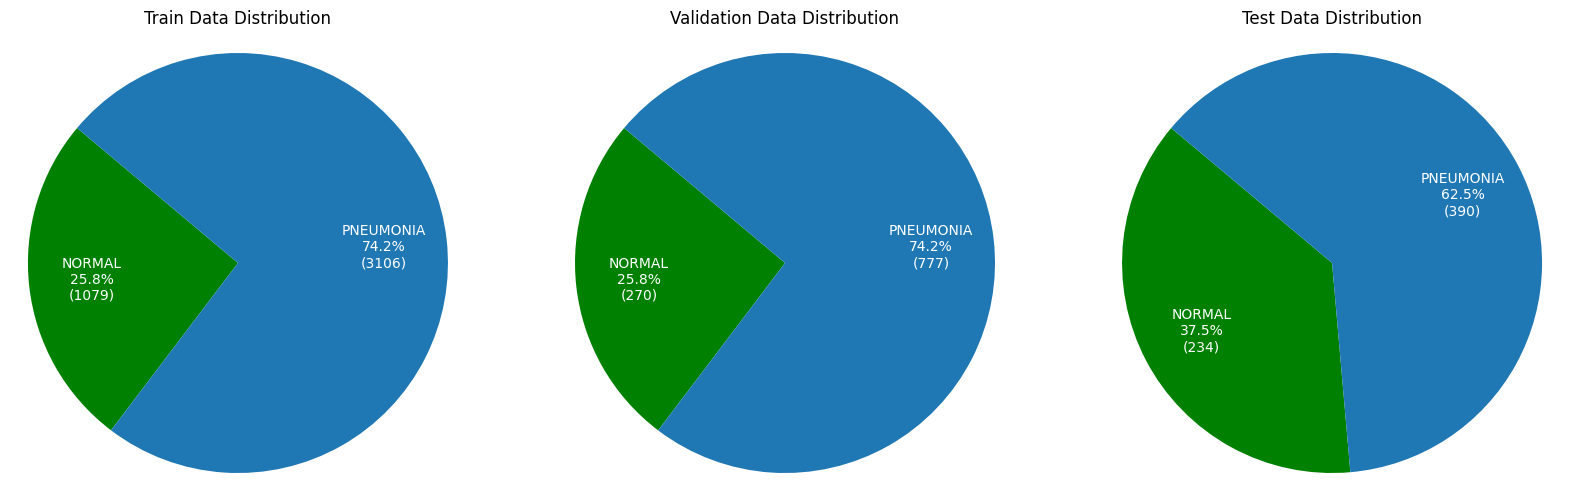

In [13]:
train_val_data_df = pd.concat([train_data_df, val_data_df], ignore_index=True)

# create a proper split of the data
train_df, val_df = train_test_split(train_val_data_df, test_size = 0.20, random_state = SEED, stratify = train_val_data_df['encoded_label'])
print(f'Label counts in train split\n {train_df["encoded_label"].value_counts()}') 
print(f'\nLabel counts in val split\n {val_df["encoded_label"].value_counts()}')
print(f'\nLabel counts in test split\n {test_data_df["encoded_label"].value_counts()}')
# plot pie chart of the data distribution with custom colors and white text for percentages and labels inside the slices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

def plot_pie(ax, data, title):
    # sort counts so that index 0 (NORMAL) comes first and index 1 (PNEUMONIA) next
    counts = data['encoded_label'].value_counts().sort_index()
    colors = ['green', '#1f77b4']
    wedges, texts, autotexts = ax.pie(
        counts, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
        pctdistance=0.7
    )
    total = counts.sum()
    for i, autotext in enumerate(autotexts):
        pct = counts[i] / total * 100
        autotext.set_text(f"{CLASS_NAMES[i]}\n{pct:.1f}%\n({counts[i]})")
    ax.set_title(title, color='white')
    ax.axis('equal')
    [t.set_color('white') for t in autotexts]

plot_pie(axes[0], train_df, "Train Data Distribution")
axes[0].set_title("Train Data Distribution", color='black')
plot_pie(axes[1], val_df, "Validation Data Distribution")
axes[1].set_title("Validation Data Distribution", color='black')
plot_pie(axes[2], test_data_df, "Test Data Distribution")
axes[2].set_title("Test Data Distribution", color='black')
plt.savefig("output/data_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


In [7]:
# save the dataframes to csv files
train_df.to_csv("data/train_data.csv", index=False)
val_df.to_csv("data/val_data.csv", index=False)
test_data_df.to_csv("data/test_data.csv", index=False)

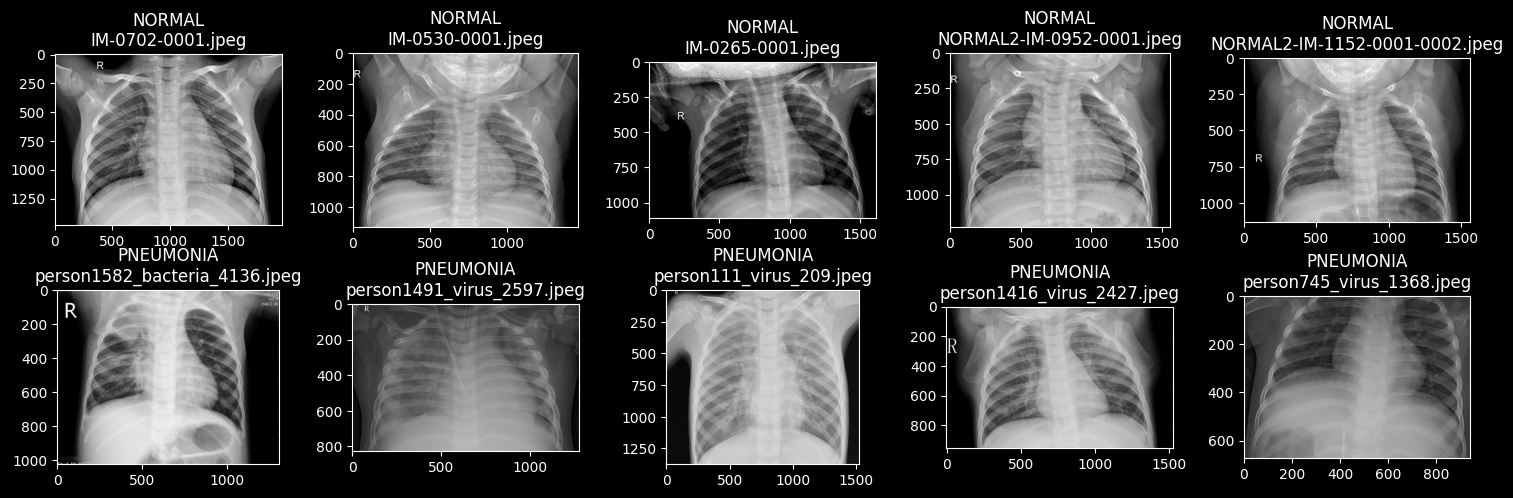

In [8]:
# display some images
def display_images(CLASS_NAMES, train_data, n=5):
    plt.figure(figsize=(15, 5))
    for i, class_name in enumerate(CLASS_NAMES):
        sample_indices = train_data[train_data['label'] == class_name].sample(n).index # get random sample indices
        sample_filepaths = train_data.loc[sample_indices, 'filepath'].tolist() # get filepaths for the sample indices

        for j, filepath in enumerate(sample_filepaths):
            try:
                img = Image.open(filepath)
                ax = plt.subplot( 2, n, i * n + j + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{class_name}\n{os.path.basename(filepath)}")
            except Exception as e:
                print(f"Error loading or displaying image {filepath}: {e}")
    plt.tight_layout()
    plt.show()


# Display some images from the dataset
display_images(CLASS_NAMES, train_data_df)



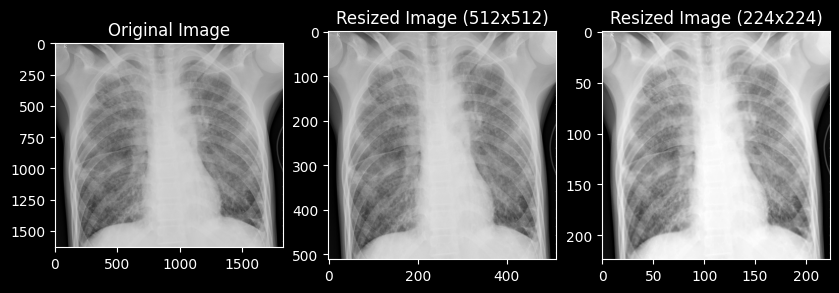

In [16]:
# load image person810_virua_1446.jpeg
def load_image(filepath):
    try:
        img = Image.open(filepath)
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((224, 224))  # Resize to 224x224
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")
        return None
# load image
image = Image.open("data/train/PNEUMONIA/person810_virus_1446.jpeg")
# resize image to 224x224
img_224 = Image.open("data/train/PNEUMONIA/person810_virus_1446.jpeg").resize((224, 224))

img_512 = Image.open("data/train/PNEUMONIA/person810_virus_1446.jpeg").resize((512, 512))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 3)
plt.imshow(img_224, cmap='gray')
plt.title("Resized Image (224x224)")
plt.subplot(1, 3, 2)
plt.imshow(img_512, cmap='gray')
plt.title("Resized Image (512x512)")
plt.show()



Unique image modes: (array(['L', 'RGB'], dtype='<U3'), array([5573,  283]))
Not all images are grayscale. Some images are RGB or have other modes.
Minimum image size index: [1367 1367]
Minimum image size: [384 127]
Maximum image size: [2916 2713]


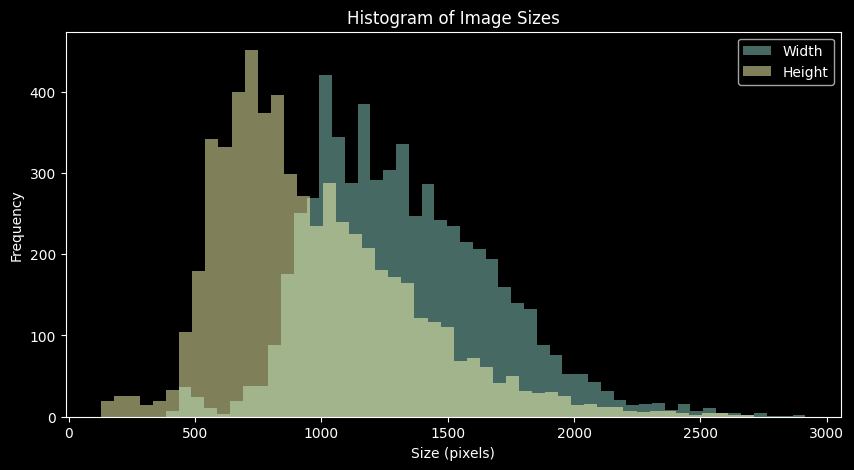

In [19]:
# examine image sizes
image_paths = train_data_df['filepath'].tolist() + val_data_df['filepath'].tolist() + test_data_df['filepath'].tolist()
image_sizes = []
for filepath in image_paths:
    try:
        img = Image.open(filepath)
        image_sizes.append(img.size)
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")

# determine if images are grayscale or RGB
image_modes = []
for filepath in image_paths:
    try:
        img = Image.open(filepath)
        image_modes.append(img.mode)
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")
# determine if images are grayscale or RGB
image_modes = np.array(image_modes)
# count of each mode


unique_modes = np.unique(image_modes, return_counts=True)
# count of each mode
print(f"Unique image modes: {unique_modes}")

# check if all images are grayscale
if np.all(image_modes == 'L'):
    print("All images are grayscale.")
else:
    print("Not all images are grayscale. Some images are RGB or have other modes.")


# Convert to numpy array for easier manipulation
image_sizes = np.array(image_sizes)
min_size = image_sizes.min(axis=0)
min_size_idx = np.argmin(image_sizes, axis=0)
print(f"Minimum image size index: {min_size_idx}")
max_size = image_sizes.max(axis=0)
print(f"Minimum image size: {min_size}")
print(f"Maximum image size: {max_size}")
# Plot histogram of image sizes
plt.figure(figsize=(10, 5))
plt.hist(image_sizes[:, 0], bins=50, alpha=0.5, label='Width')
plt.hist(image_sizes[:, 1], bins=50, alpha=0.5, label='Height')
plt.title('Histogram of Image Sizes')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
print(image_sizes[1367])
print(index_to_filename[1367])
# Display the image with the minimum size
min_size_image_path = image_paths[min_size_idx[0]]
min_size_image = Image.open(min_size_image_path)
plt.imshow(min_size_image)
plt.title(f"Minimum Size Image: {min_size_image_path}")
plt.axis('off')
plt.show()

[384 127]


NameError: name 'index_to_filename' is not defined